In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [3]:
import numpy as np
def whiten(X, method='zca'):
    """
    Whitens the input matrix X using specified whitening method.
    Inputs:
        X:      Input data matrix with data examples along the first dimension
        method: Whitening method. Must be one of 'zca', 'zca_cor', 'pca',
                'pca_cor', or 'cholesky'.
    """
    X = X.reshape((-1, np.prod(X.shape[1:])))
    X_centered = X - np.mean(X, axis=0)
    Sigma = np.dot(X_centered.T, X_centered) / X_centered.shape[0]
    W = None
    if method in ['zca', 'pca', 'cholesky']:
        U, Lambda, _ = np.linalg.svd(Sigma)
    if method == 'zca':
        W = np.dot(U, np.dot(np.diag(1.0 / np.sqrt(Lambda + 1e-2)), U.T))
    elif method =='pca':
        W = np.dot(np.diag(1.0 / np.sqrt(Lambda + 1e-5)), U.T)
    elif method == 'cholesky':
        W = np.linalg.cholesky(np.dot(U, np.dot(np.diag(1.0 / (Lambda + 1e-5)), U.T))).T
    elif method in ['zca_cor', 'pca_cor']:
        V_sqrt = np.diag(np.std(X, axis=0))
        P = np.dot(np.dot(np.linalg.inv(V_sqrt), Sigma), np.linalg.inv(V_sqrt))
        G, Theta, _ = np.linalg.svd(P)
    if method == 'zca_cor':
        W = np.dot(np.dot(G, np.dot(np.diag(1.0 / np.sqrt(Theta + 1e-5)), G.T)), V_sqrt)
    elif method == 'pca_cor':
        W = np.dot(np.dot(np.diag(1.0/np.sqrt(Theta + 1e-5)), G.T), V_sqrt)
    return np.dot(X_centered, W.T)

In [158]:
import os
import cv2
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch = image.shape
        mean = 0
        var = 0.000001
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 1

      # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)* 0.000001 
        noisy = image + image * gauss
        return noisy

In [4]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [5]:
Shapes=["dot","square"]

In [8]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, highth, width, Shapes):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        #self.add_class("shapes", 1, "square")
        #self.add_class("shapes", 2, "circle")
        #self.add_class("shapes", 3, "triangle")
        #self.add_class("shapes", 4, "plus")
        #self.add_class("shapes", 5, "dot")
        #self.add_class("shapes", 6, "curve")  
        #self.add_class("shapes", 7, "line") 
        for i in range (0,len(Shapes)):
            self.add_class("shapes",i,Shapes[i])
        for i in range(count):
            shapes = self.random_image(highth, width,Shapes)
            self.add_image("shapes", image_id=i, path=None,
                   width=width, highth=highth, shapes=shapes)
    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        image = np.ones([info['highth'], info['width'], 3], dtype=np.uint8)
        for shape, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims)
        return image
    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        #print(info['shapes'])
        shapes = info['shapes']
        count = len(shapes)
        mask = np.ones([info['highth'], info['width'], count], dtype=np.uint8)
        for i, (shape, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims).reshape(info['highth'],info['width'],1)
        #for i, (shape, dims) in enumerate(info['shapes']):
        #    mask[:, :] = self.draw_shape(mask[:, :].copy(),
        #                                        shape, dims)  
        # Handle occlusions
        #occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        #for i in range(count-2, -1, -1):
        #    mask[:, :, i] = mask[:, :, i] * occlusion
        #    occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        #return mask.astype(np.bool), class_ids.astype(np.int32)
        return mask, class_ids.astype(np.int32)
    def draw_shape(self, image, shape, dims):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x, y), (x+s, y+s), -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, -1)
        elif shape == "triangle":
            cv2.line(image,(x,y),(y,s),-1)
            cv2.line(image,(y,s),(s,x),-1)
            cv2.line(image,(s,x),(x,y),-1)
        elif shape == "plus":
            cv2.line(image,(x,y),(x+s,y),-1)
            cv2.line(image,(int(x+s/2),int(y-s/2)),(int(x+s/2),int(y+s/2)),-1)
        elif shape == "dot":
            cv2.circle(image, (x, y), s,(0,0,255), -1)
        elif shape == "curve":
            a=np.arange(width)
            b=np.sin(a*x)
            pts=[]
            if random.randint(1,2)==1:
                for i in range (0,width):
                    pts.append([a[i],int(y*b[i]+y+s)])
            else:
                for i in range (0,highth):
                    pts.append([int(y*b[i]+y+s),a[i]])
            line_width=random.randint(1,3)
            cv2.polylines(image, [np.array(pts)], False, (0,0,255),thickness=line_width, lineType=cv2.LINE_8)
        elif shape == "line":
            if random.randint(1,2)==1:
                cv2.line(image,(x,y),(x+s,y),-1)
            else:
                cv2.line(image,(int(x+s/2),int(y-s/2)),(int(x+s/2),int(y+s/2)),-1)        
        return image
    def random_shape(self, highth, width, Shapes):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        #shape = random.choice(["square", "circle", "triangle", "line", "curve", "dot", "plus"])
        shape=random.choice(Shapes)
        # Color
        # Center x, y
        x=random.randint(5,width-5)
        y=random.randint(5,highth-5)
        s=random.randint(5,np.minimum(width-x,highth-y))
        if shape == "dot":
            s=random.randint(1,10)
        elif shape == "curve":
            x=random.randint(1,5)*0.1
            y=random.randint(5,width/2)
            s=random.randint(0,width-2*y)
        return shape, (x, y, s)
    def random_image(self, highth, width,Shapes):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        #bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, dims = self.random_shape(highth, width,Shapes)
            shapes.append((shape, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return shapes

In [9]:
Shapes=["dot","square"]
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1],Shapes)
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1],Shapes)
dataset_val.prepare()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


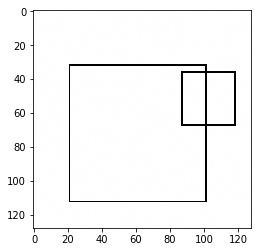

In [176]:
plt.imshow(image)

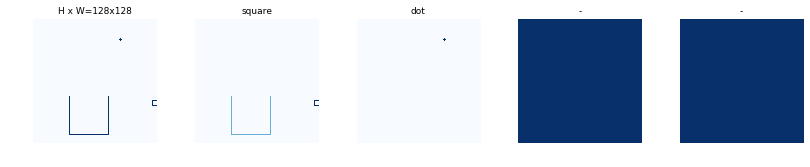

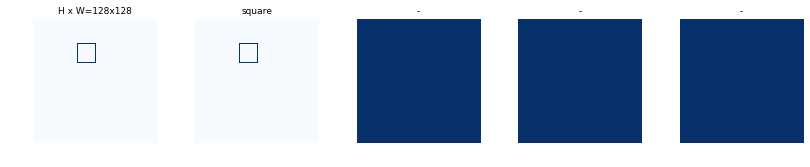

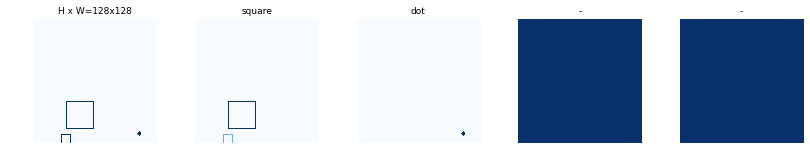

In [178]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 3)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image[:,:,0], mask, class_ids, dataset_train.class_names)

In [179]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [180]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [241]:
MODEL_DIR

'/Users/sofiadunlosky/Downloads/Mask_RCNN-master/logs'

In [ ]:


# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

In [182]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /Users/sofiadunlosky/Downloads/Mask_RCNN-master/logs/shapes20190519T1949/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b 

100/100 [==============================] - 3431s 34s/step - loss: 0.1109 - rpn_class_loss: 6.3248e-04 - rpn_bbox_loss: 0.0029 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.0833 - val_loss: 0.1289 - val_rpn_class_loss: 6.2202e-04 - val_rpn_bbox_loss: 0.0029 - val_mrcnn_class_loss: 0.0183 - val_mrcnn_bbox_loss: 0.0018 - val_mrcnn_mask_loss: 0.1053


original_image           shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max:  128.00000  int64
gt_class_id              shape: (4,)                  min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (4, 4)                min:    0.00000  max:  128.00000  int32
gt_mask                  shape: (128, 128, 4)         min:    0.00000  max:    1.00000  uint8


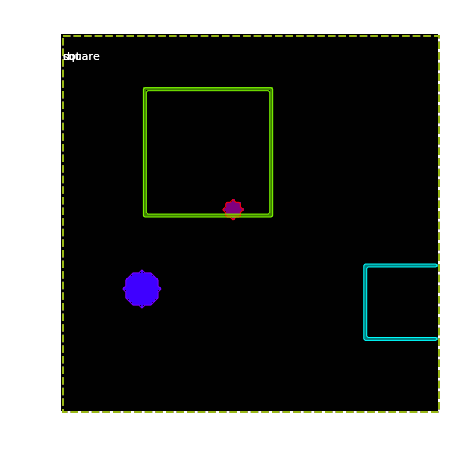

In [83]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
gt_mask=np.logical_not(gt_mask).astype(np.bool)
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

original_image           shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max:  128.00000  int64
gt_class_id              shape: (2,)                  min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (2, 4)                min:    0.00000  max:  128.00000  int32
gt_mask                  shape: (128, 128, 2)         min:    0.00000  max:    1.00000  uint8


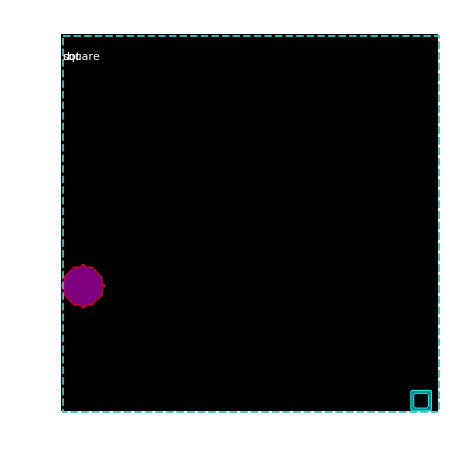

In [44]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
gt_mask=np.logical_not(gt_mask).astype(np.bool)
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [45]:
original_image

array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [1, 1, 1],
        [1, 1, 1]]], dtype=uint8)

In [6]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()
#model.load_weights('/Users/sofiadunlosky/Downloads/Mask_RCNN-master/logs/shapes20190516T1725/mask_rcnn_shapes_0002.h5', by_name=True)
# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Loading weights from  /Users/sofiadunlosky/Downloads/Mask_RCNN-master/logs/shapes20190520T2048/mask_rcnn_shapes_0003.h5
Re-starting from epoch 3


In [10]:
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.4333333343267441


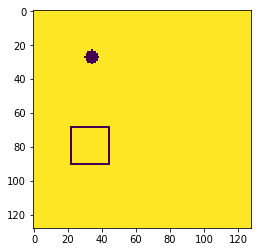

In [80]:
plt.imshow(dataset_train.load_image(5)[:,:,0])

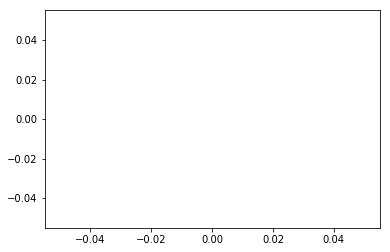

In [81]:
A=model.detect([dataset_train.load_image(4)])
C=np.where(A[0]['masks']==False)
plt.scatter(C[0],C[1])

In [77]:
pic=np.load('pic.npy')

In [51]:
pic[:,:,0]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

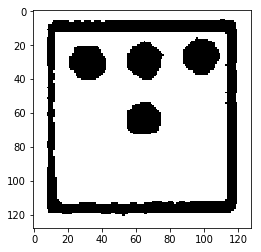

In [48]:
pic[:,:,0][pic[:,:,0]<=200]=0
pic[:,:,0][pic[:,:,0]>200]=1
plt.imshow(pic[:,:,0],cmap='gray')

[{'rois': array([], shape=(0, 4), dtype=int32),
  'class_ids': array([], dtype=int32),
  'scores': array([], dtype=float32),
  'masks': array([], shape=(128, 128, 0), dtype=float64)}]

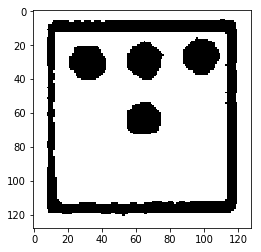

In [56]:
p=np.zeros((128,128,3))

for i in range (0,3):
    p[:,:,i]=pic[:,:,0]
plt.imshow(p)
model.detect([p])

In [22]:
im=np.load('im.npy')

In [23]:
im.shape

(128, 128)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


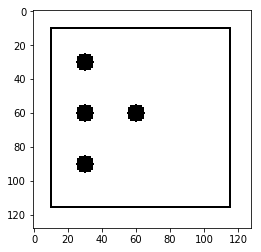

In [69]:
p=np.zeros((128,128,3))
for i in range (0,3):
    p[:,:,i]=im[:,:]
plt.imshow(p)
A=model.detect([p])

In [70]:
C=np.where(A[0]['masks']==False)

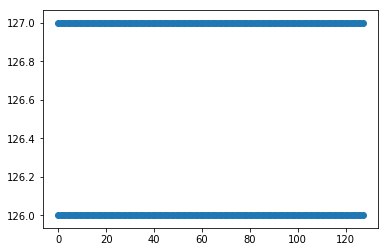

In [71]:
plt.scatter(C[0],C[1])

In [35]:
A[0]['class_ids'][0]

2

In [240]:
class_ids

array([2, 1, 2], dtype=int32)